In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import math
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.metrics import categorical_accuracy

#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger

In [3]:
# get all the directories of the data
train= '/content/drive/MyDrive/Colab Notebooks/primary_small/train'
valid= '/content/drive/MyDrive/Colab Notebooks/primary_small/valid'
test= '/content/drive/MyDrive/Colab Notebooks/primary_small/test'
classes = ["brightpixel", "narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]

In [4]:
train_batch_size = 32
img_dim = (80, 80)
classes = ['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband']

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     zoom_range=0.2,
                                     fill_mode = 'nearest') 
valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=train, classes=classes, target_size=img_dim, 
                                                    batch_size=train_batch_size, class_mode='categorical', interpolation='bicubic',
                                                   shuffle=True, seed=42)

val_generator = valid_datagen.flow_from_directory(directory=valid, classes = classes, target_size=img_dim, batch_size=64,
                                                 class_mode='categorical', shuffle=False, seed=42, interpolation='bicubic')

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.0)

test_generator = test_datagen.flow_from_directory(directory=test, classes = classes, target_size=img_dim, batch_size=64,
                                                 class_mode='categorical', shuffle=False, seed=42, interpolation='bicubic')

Found 700 images belonging to 7 classes.


In [ ]:
#xtrain=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
#ytrain=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
xval=np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])
yval=np.concatenate([val_generator.next()[1] for i in range(val_generator.__len__())])
#print(xtrain.shape)
#print(ytrain.shape)
print(xval.shape)
print(yval.shape)

(700, 80, 80, 3)
(700, 7)


In [ ]:
xtest=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
ytest=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])

In [ ]:
img = np.concatenate([xval,xtest])
lable = np.concatenate([yval,ytest])

In [5]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img, lable, test_size=0.33, random_state=42)

In [6]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
np.save('X_train_QCNN', X_train)
np.save('X_test_QCNN', X_test)
np.save('y_train_QCNN', y_train)
np.save('y_test_QCNN', y_test)

In [7]:
X_train =np.load('X_train_QCNN.npy')
X_test =np.load('X_test_QCNN.npy')
y_train = np.load('y_train_QCNN.npy')
y_test = np.load('y_test_QCNN.npy')

In [8]:
n_train = len(y_train)
n_test = len(y_test)

In [9]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.7 MB/s eta 0:00:00


In [10]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [11]:
n_layers = 4    # Number of random layers


SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)  

In [12]:
dev = qml.device("default.qubit", wires=4,shots = 500)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi=None):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [13]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((40,40, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0,80, 2):  #for j in range(0, 28, 2):
        for k in range(0,80, 2):  #for k in range(0, 28, 2):
          
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                phi=[
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [14]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(X_train):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(X_test):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)


Quantum pre-processing of train images:

Quantum pre-processing of test images:


In [ ]:
np.save('q_train_images_l4_500', q_train_images)
np.save('q_test_images_l4_500', q_test_images)
#ValueError: 'rgb' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocea...


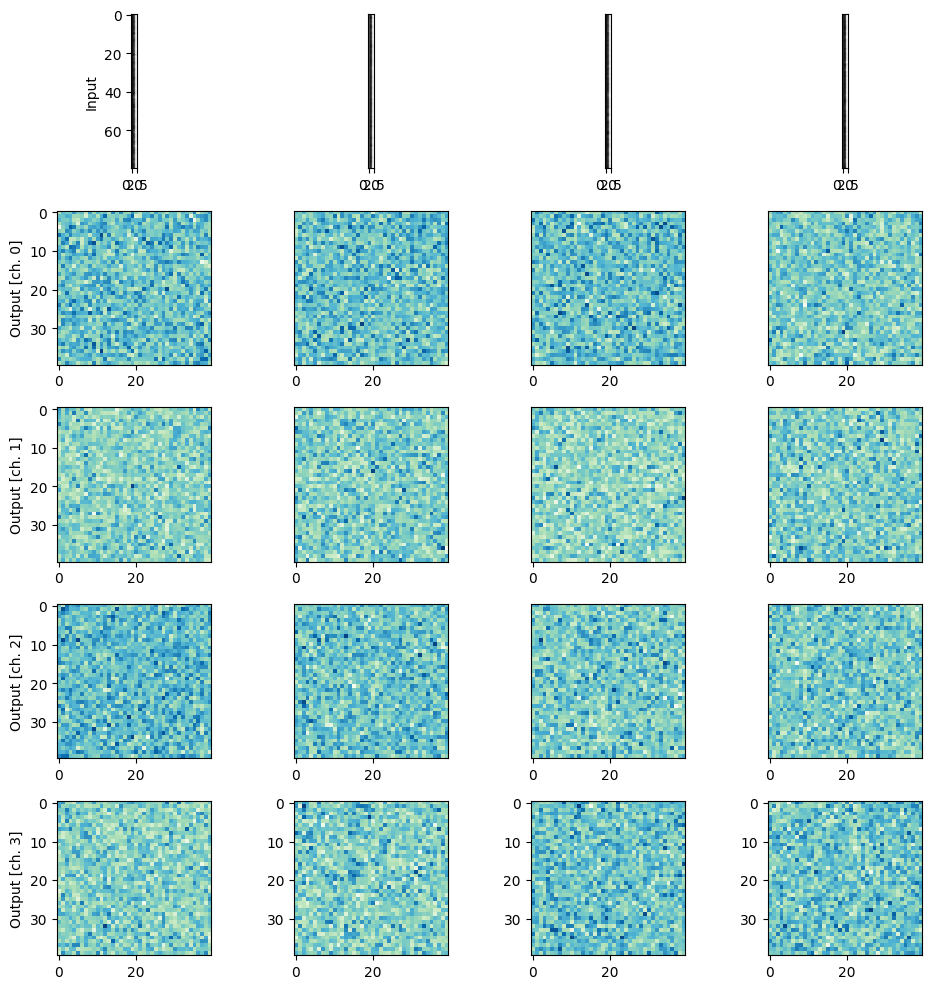

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-88b05f4f9ff1>", line 19, in <cell line: 19>
    plt.savefig('QCNN_4_500.png', dpi =300)
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/figure.py", line 3343, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/backend_bases.py", line 2366, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/backend_bases.py", line 2232, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/backends/backend_agg.py", line 509, in print_png
    self._prin

<Figure size 640x480 with 0 Axes>

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(X_train[k, :, 1], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap='GnBu_r')

plt.tight_layout()
plt.show()
plt.savefig('QCNN_4_500.png', dpi =300)

In [24]:
from tensorflow.keras.layers.experimental import RandomFourierFeatures 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D 
from tensorflow.python.keras import regularizers


In [25]:
ytrain1 = y_train[:,0]
yval1 = y_test[:,0]
print(ytrain1.shape)
print(yval1.shape)
print(q_train_images.shape)
print(q_test_images.shape)

(938,)
(462,)
(938, 40, 40, 4)
(462, 40, 40, 4)


In [26]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.SeparableConv2D(512, (3,3), strides=(1, 1), activation="elu", kernel_regularizer=regularizers.l2(l=0.01)),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l=0.01)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(7, activation="softmax")
    ])

    model.compile(
        optimizer='sgd',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [27]:
#def MyModel():
   # """Initializes and returns a custom Keras model
   # which is ready to be trained."""
   # model = keras.models.Sequential([
    #    keras.layers.SeparableConv2D(128, (3,3), strides=(1, 1), activation="elu", kernel_regularizer=regularizers.l2(l=0.01)),  
    #    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),                                                       
        #keras.layers.Dense(512, activation="elu"),  
    #    keras.layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(l=0.01)), 
                                    
     #   keras.layers.Flatten(),
        
     #   keras.layers.Dense(7, activation="softmax")
  #  ])

    #model.compile(
     #   optimizer='nadam',
      #  loss="sparse_categorical_crossentropy",
      #  metrics=["accuracy"],
   # )
    
    #return model

In [18]:
def MyModel1():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.SeparableConv2D(512, (3,3), strides=(1, 1), activation="elu", kernel_regularizer=regularizers.l2(l=0.01)),  
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),                                                       
        #keras.layers.Dense(512, activation="elu"),  
        keras.layers.Dense(128, activation="elu", kernel_regularizer=regularizers.l2(l=0.01)), 
                                    
        keras.layers.Flatten(),
        
        keras.layers.Dense(7, activation="softmax")
    ])

    model.compile(
        optimizer='sgd',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    ytrain1,
    validation_data=(q_test_images, yval1),
    batch_size=4,
    epochs=100,
    verbose=2,
)
print(q_history.history.keys())
#  "Accuracy"
plt.plot(q_history.history['accuracy'])
plt.plot(q_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(q_history.history['loss'])
plt.plot(q_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/100
235/235 - 202s - loss: 2.9600 - accuracy: 0.8465 - val_loss: 2.7239 - val_accuracy: 0.8723 - 202s/epoch - 861ms/step
Epoch 2/100
235/235 - 208s - loss: 2.6776 - accuracy: 0.8486 - val_loss: 2.5030 - val_accuracy: 0.8723 - 208s/epoch - 883ms/step
Epoch 3/100
235/235 - 211s - loss: 2.4772 - accuracy: 0.8497 - val_loss: 2.3182 - val_accuracy: 0.8723 - 211s/epoch - 896ms/step
Epoch 4/100
235/235 - 202s - loss: 2.2897 - accuracy: 0.8497 - val_loss: 2.1470 - val_accuracy: 0.8723 - 202s/epoch - 858ms/step
Epoch 5/100
235/235 - 208s - loss: 2.1195 - accuracy: 0.8497 - val_loss: 2.0015 - val_accuracy: 0.8723 - 208s/epoch - 884ms/step
Epoch 6/100
235/235 - 224s - loss: 1.9677 - accuracy: 0.8497 - val_loss: 1.8442 - val_accuracy: 0.8723 - 224s/epoch - 955ms/step
Epoch 7/100
235/235 - 213s - loss: 1.8286 - accuracy: 0.8497 - val_loss: 1.7033 - val_accuracy: 0.8723 - 213s/epoch - 904ms/step
Epoch 8/100
235/235 - 237s - loss: 1.7011 - accuracy: 0.8497 - val_loss: 1.6163 - val_accuracy: 0

In [ ]:
print("Training Score: ", q_model.evaluate(q_train_images, ytrain1))

In [ ]:
print("Val Score: ", q_model.evaluate(q_test_images, yval1))

In [19]:
q_model4 = MyModel()

In [20]:
q_model3 = MyModel()

In [21]:
img = np.concatenate([q_train_images, q_test_images])
lab = np.concatenate([ytrain1, yval1])

In [22]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=128):
    model = None
    results = q_model3.fit(t_x, t_y, epochs=10, batch_size=64, 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", q_model3.evaluate(val_x, val_y))
    return results

In [ ]:
n_folds=3
epochs=50
batch_size=8

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(img, lab, test_size=0.1)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
plt.savefig('FOLDCOMP_L1_500.png', dpi =300)

In [23]:
q_model3